## Problem 1

Using cla_brown, mean = 150.00, std = 0.60
Using arith, mean = 149.00, std = 91.19
Using geo_brown, mean = 179.08, std = 116.14


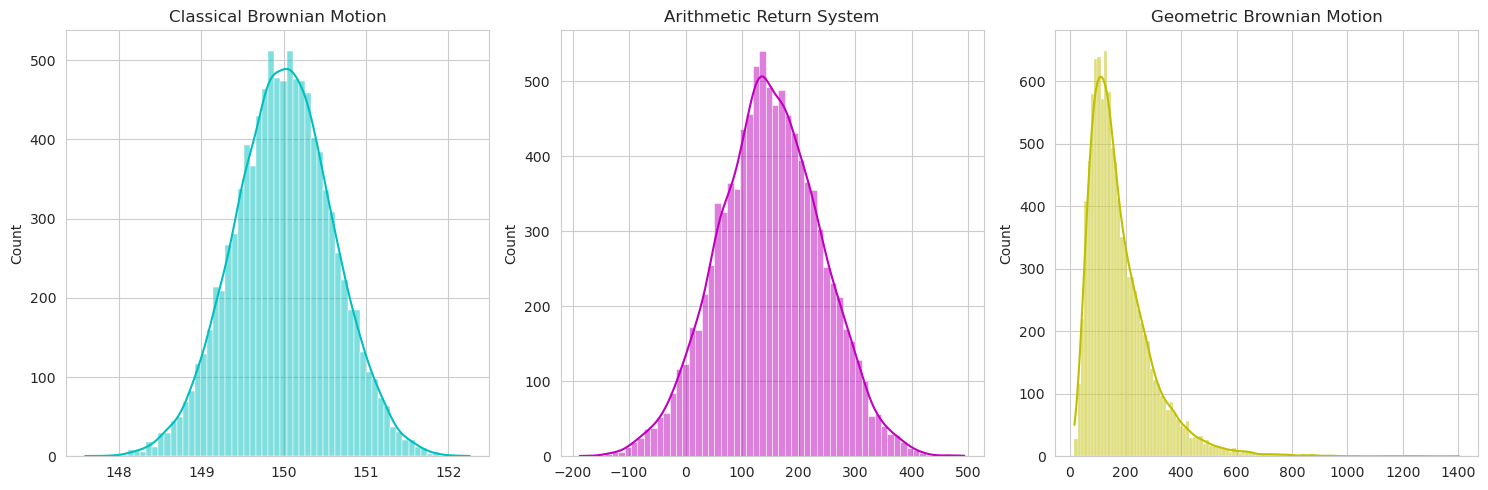

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, norm, normaltest
from statsmodels.tsa.arima.model import ARIMA

sns.set_style("whitegrid")
sns.set_palette("husl")

# Helper Functions

def simulate_price(method, P0, std, N):
    r = np.random.normal(0, std, N)
    
    if method == "cla_brown":
        return P0 + r
    elif method == "arith":
        return P0 * (1+r)
    elif method == "geo_brown":
        return P0 * np.exp(r)
    else:
        raise ValueError("Invalid method!")

# Parameters
P0 = 150
std = 0.6
N = 10000

# Simulate Prices
methods = ["cla_brown", "arith", "geo_brown"]
results = {method: simulate_price(method, P0, std, N) for method in methods}

# Display Results
for method, prices in results.items():
    print(f"Using {method}, mean = {np.mean(prices):.2f}, std = {np.std(prices):.2f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(results['cla_brown'], ax=axes[0], kde=True, color="c")
sns.histplot(results['arith'], ax=axes[1], kde=True, color="m")
sns.histplot(results['geo_brown'], ax=axes[2], kde=True, color="y")
axes[0].set_title("Classical Brownian Motion")
axes[1].set_title("Arithmetic Return System")
axes[2].set_title("Geometric Brownian Motion")
plt.tight_layout()
plt.show()

## Problem 2

In [20]:
import warnings
warnings.filterwarnings('ignore')
def return_calculate(prices: pd.DataFrame, method="ARITHMETIC", dateColumn="Date") -> pd.DataFrame:
    vars = [col for col in prices.columns if col != dateColumn]
    
    # Calculate returns
    p = prices[vars].values
    p2 = p[1:] / p[:-1]
    
    if method.upper() == "ARITHMETIC":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in ('LOG','ARITHMETIC')")
    
    out = pd.DataFrame({dateColumn: prices[dateColumn].iloc[1:].values})
    for var, col in zip(vars, p2.T):
        out[var] = col
    return out

# Testing the return_calculate function
price_df = pd.read_csv('DailyPrices.csv')
returns = return_calculate(price_df)
META_ret = returns['META']

# Adjusting mean of META returns to 0
META_ret0 = META_ret - META_ret.mean()

META_ret0.head()

0   -0.033266
1   -0.013890
2    0.008882
3    0.007625
4    0.040962
Name: META, dtype: float64

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# VaR using a normal distribution
def norml_var(returns, alpha=0.05, N=10000):
    mean, std = returns.mean(), returns.std()
    Rt = np.random.normal(mean, std, N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

# VaR using a normal distribution with an Exponentially Weighted variance
def norml_ew_var(returns, alpha=0.05, N=10000, w_lambda=0.94):
    mean = returns.mean()
    std = np.sqrt(exp_w_variance(returns))
    Rt = np.random.normal(mean, std, N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

def norml_ew_var(returns, alpha = 0.05, N = 10000):
        mean = returns.mean()
        std = np.sqrt(exp_w_variance(returns))
        Rt = np.random.normal(mean, std, N)
        Rt.sort()
        var = Rt[int(alpha * len(Rt))] * (-1)
        #print(-np.percentile(returns, alpha*100))
        return var, Rt

# VaR using a MLE fitted T distribution
def MLE_T_var(returns, alpha=0.05, N=10000):
    df, loc, scale = t.fit(returns)
    Rt = t(df, loc, scale).rvs(N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

# VaR using a fitted AR(1) model
def ar1_var(returns, alpha=0.05, N=10000):
    model = ARIMA(returns, order=(1, 0, 0))
    result = model.fit()
    predicted_mean = result.forecast(steps=1).values[0]
    resid_std = np.std(result.resid)
    Rt = predicted_mean + np.random.normal(0, resid_std, N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

# VaR using a historic simulation
def his_var(returns, alpha=0.05):
    Rt = returns.sort_values().values
    var = -Rt[int(alpha * len(Rt))]
    return var, Rt

# Calculating VaR for different methods
var_nor, Rt_nor = norml_var(META_ret0)
var_ew, Rt_ew = norml_ew_var(META_ret0)
var_T, Rt_T = MLE_T_var(META_ret0)
var_ar1, Rt_ar1 = ar1_var(META_ret0)
var_his, Rt_his = his_var(META_ret0)

var_values = {
    "Normal Distribution": var_nor,
    "Exponentially Weighted Variance": var_ew,
    "MLE fitted T Distribution": var_T,
    "AR(1) Model": var_ar1,
    "Historic Simulation": var_his
}

var_values

{'Normal Distribution': 0.054707265915804694,
 'Exponentially Weighted Variance': 0.030719253464518263,
 'MLE fitted T Distribution': 0.04192166631600979,
 'AR(1) Model': 0.05395185599442447,
 'Historic Simulation': 0.0395076854830965}

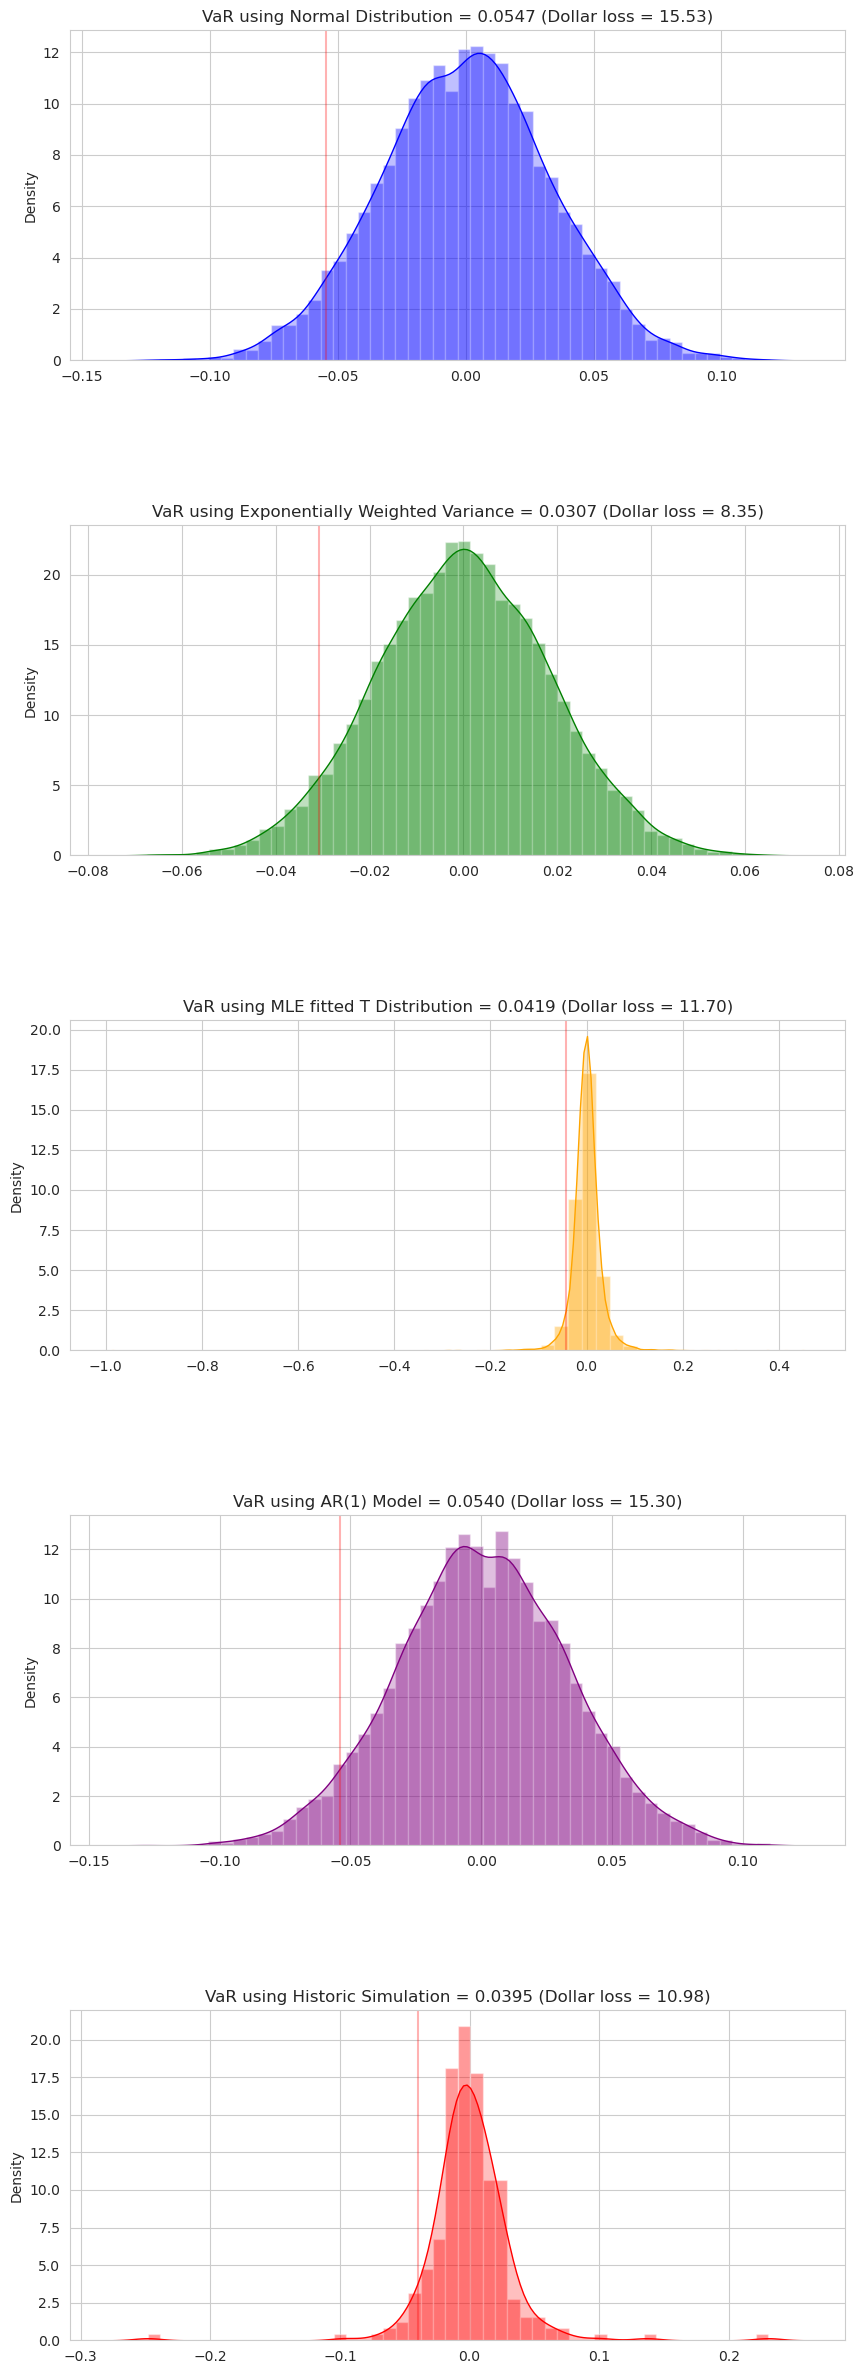

{'Normal Distribution': 15.528271676723222,
 'Exponentially Weighted Variance': 8.353937224636637,
 'MLE fitted T Distribution': 11.704354714629357,
 'AR(1) Model': 15.302343687257153,
 'Historic Simulation': 10.9823813585034}

In [22]:
# Convert VaR to dollar loss
def ret_to_dollar(ret_var, return_s, price_s):
    dollar_var = (ret_var - return_s.mean()) * price_s.values[-1]
    return dollar_var

# VaR in dollar loss for different methods
var_dollar_values = {
    method: ret_to_dollar(value, META_ret, price_df['META'])
    for method, value in var_values.items()
}

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distributions
fig, axes = plt.subplots(5, 1, figsize=(10, 30))

sns.distplot(Rt_nor, ax=axes[0], color='blue', kde_kws={"shade": True})
sns.distplot(Rt_ew, ax=axes[1], color='green', kde_kws={"shade": True})
sns.distplot(Rt_T, ax=axes[2], color='orange', kde_kws={"shade": True})
sns.distplot(Rt_ar1, ax=axes[3], color='purple', kde_kws={"shade": True})
sns.distplot(Rt_his, ax=axes[4], color='red', kde_kws={"shade": True})

methods = list(var_values.keys())
for ax, method, var in zip(axes, methods, var_values.values()):
    ax.axvline(x=-var, color='red', alpha=0.3)
    ax.set_title(f"VaR using {method} = {var:.4f} (Dollar loss = {var_dollar_values[method]:.2f})")

plt.subplots_adjust(hspace=0.5)
plt.show()

var_dollar_values